# thal1 Fourier Coefficients

Get Fourier coefficients for $\mathcal{H}$-functions. To be used to generate two-parameter bifurcation diagrams.

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal1 as t1
from lib.functions import g1,p

#from lib.util import (get_phase, _get_sol,load_bif1d_f,load_phis_force, get_init_point_force, )

from generate_figures import _full_thal1

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import add_diagram_1d

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-6,'atol':1e-6,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r'],
        'pardict':pd1,
        'rhs':t1.rhs,
        #'forcing_fn':[lambda x: -np.cos(x),lambda x:20*np.cos(x+1)],
        'forcing_fn':[g1,lambda x:-20*g1(x+1)],
        'init':np.array([-.64,0.71,0,10.6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':False,
        'i_bad_dx':[False,True,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1,
        'save_fig':True}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
def get_coeffs(a,k):
    coeffs = np.fft.fft(a.system1.h['dat'][k])
    
    # get coeffs above threshold
    threshold = 0.1
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<a.NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<a.NH/2)
    
    print(coeffs_re_bool.sum(),np.where(coeffs_re_bool>0))
    print(coeffs_im_bool.sum(),np.where(coeffs_im_bool>0))
    
    print('re',coeffs_re_all[coeffs_re_bool])
    print('im',coeffs_im_all[coeffs_im_bool])
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a11.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a11.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a11.NH
    return eq


## Initialize Response Functions

In [9]:
system1 = rsp(idx=0,model_name='thalf0',**kws1)

mkdir ./data/thalf0/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981420040301
LC0 ini[-0.10742889  0.22848616  0.09385013]
LC0 fin[-0.10742888  0.22848617  0.09385012]
* Loading monodromy...
* Floquet Exponent kappa =-0.024354476053972264
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0.]
g0 fin[0. 0. 0.]
g1 ini[-0.00392138  0.93590097  0.35224138]
g1 fin[-0.00392138  0.93590097  0.35224138]
* Loading heterogeneous terms...
* Computing z...
z0 ini[-0.86890695 -1.20965439  3.20436344]
z0 fin[-0.86890694 -1.20965437  3.20436339]
z1 ini[ 2.63290751  1.04789014 -0.20900062]
z1 fin[ 2.63290751  1.04789014 -0.20900062]
* Computing i...
i0 ini[ 0.14832161 -0.01130593  2.87065321]
i0 fin[ 0.14832161 -0.01130593  2.87065321]
i1 ini[-0.08308497  0.69291962 -0.06360566]
i1 fin[-0.08308503  0.69291955 -0.06360565]


# 1:1

In [10]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm11 = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',1),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [11]:
del11_p01 = 0.01
a11 = nm.nmCoupling(**kw_nm11, del1=del11_p01)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_thalf0_v0[1]*p_thalf0[1] + eps**2*(f1*i_thalf0_v0[1]*p_thalf0[1] + f2*i_thalf0_v0[0]) + eps*f1*i_thalf0_v0[0]
p sym k 0
p sym k f_imp1(th1)*iv0_0(th0)
h sym 0 f_imp1(th1)*zv0_0(th0)
h sym 1 f_imp1(th1)*zv0_1(th0)*p_thalf0[1] + f_imp2(th1)*zv0_0(th0)
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


Might need to stick with Fourier coefficients. At least for CGL. Much simpler this way.

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

## eps coeffs

In [12]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,0)

4 (array([1, 2, 3, 4]),)
4 (array([1, 2, 3, 4]),)
re [5.91663184e+02 6.08190558e+01 7.16041352e+00 4.95952205e-01]
im [-656.12918255  -38.17516767    7.12827312    0.97103573]


In [13]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*1.0)*(0.5778)+2*cos(x*2.0)*(0.0594)+2*cos(x*3.0)*(0.0070)+2*cos(x*4.0)*(0.0005)-2*sin(x*1.0)*(-0.6408)-2*sin(x*2.0)*(-0.0373)-2*sin(x*3.0)*(0.0070)-2*sin(x*4.0)*(0.0009)


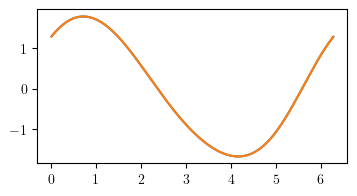

In [14]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][0])

## eps^2 coeffs

In [15]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,1)

7 (array([0, 1, 2, 3, 4, 5, 6]),)
7 (array([1, 2, 3, 4, 5, 6, 7]),)
re [ 2.34386311e+03  4.94670324e+03  9.41119832e+02  2.38562375e+02  3.10999141e+01 -2.31010159e+00 -2.16862610e-01]
im [1.68322243e+04 2.01861543e+03 4.23684427e+02 1.46508090e+00 1.27827257e+00 1.16680318e+00 1.75557251e-01]


In [16]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

2.2889+2*cos(x*1.0)*(4.8308)+2*cos(x*2.0)*(0.9191)+2*cos(x*3.0)*(0.2330)+2*cos(x*4.0)*(0.0304)+2*cos(x*5.0)*(-0.0023)+2*cos(x*6.0)*(-0.0002)-2*sin(x*1.0)*(16.4377)-2*sin(x*2.0)*(1.9713)-2*sin(x*3.0)*(0.4138)-2*sin(x*4.0)*(0.0014)-2*sin(x*5.0)*(0.0012)-2*sin(x*6.0)*(0.0011)-2*sin(x*7.0)*(0.0002)


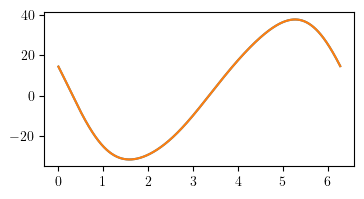

In [17]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][1])

## eps^3 coeffs

In [18]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,2)

In [19]:
# tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

In [20]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(a11.x,tot)
# axs.plot(a11.x,a11.system1.h['dat'][2])

## Save data

In [21]:
# xlo = a11.x[0]
# xhi = a11.x[-1]
# npts = len(a11.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a11.system1.miter):
#     d = a11.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a11._n[1],a11._m[1],k),d,
#               fmt='%.18f')

# 2:1

In [22]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm21 = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',1),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [23]:
del21_p01 = 0.01
a21 = nm.nmCoupling(**kw_nm21, del1=del21_p01)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_thalf0_v0[1]*p_thalf0[1] + eps**2*(f1*i_thalf0_v0[1]*p_thalf0[1] + f2*i_thalf0_v0[0]) + eps*f1*i_thalf0_v0[0]
p sym k 0
p sym k f_imp1(th1)*iv0_0(th0)
h sym 0 f_imp1(th1)*zv0_0(th0)
h sym 1 f_imp1(th1)*zv0_1(th0)*p_thalf0[1] + f_imp2(th1)*zv0_0(th0)
* Loading p...
p order=0
* Computing H thalf0, order=0...
p order=1
system1 p f_imp1(th1)*iv0_0(th0) k= 1
* Computing H thalf0, order=1...


## eps coeffs

In [24]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,0)

2 (array([2, 4]),)
2 (array([2, 4]),)
re [279.48189871   3.02800249]
im [-309.93348011   -1.90062968]


In [25]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*2.0)*(0.2729)+2*cos(x*4.0)*(0.0030)-2*sin(x*2.0)*(-0.3027)-2*sin(x*4.0)*(-0.0019)


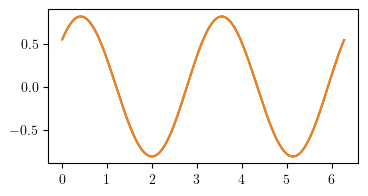

In [26]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][0])

## eps^2 coeffs

In [27]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,1)

4 (array([0, 2, 4, 6]),)
3 (array([2, 4, 6]),)
re [ 5.45765718e+02  7.97923485e+03 -4.68890286e+01  2.59208613e+00]
im [2481.04123855  199.4115724     5.67961552]


In [28]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

0.5330+2*cos(x*2.0)*(7.7922)+2*cos(x*4.0)*(-0.0458)+2*cos(x*6.0)*(0.0025)-2*sin(x*2.0)*(2.4229)-2*sin(x*4.0)*(0.1947)-2*sin(x*6.0)*(0.0055)


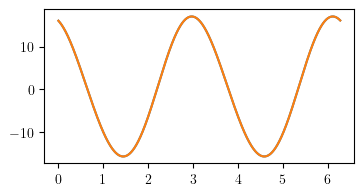

In [29]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][1])

## eps^3 coeffs

In [30]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,2)

In [31]:
# tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

In [32]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(a21.x,tot)
# axs.plot(a21.x,a21.system1.h['dat'][2])

## Save data

In [33]:
# xlo = a21.x[0]
# xhi = a21.x[-1]
# npts = len(a21.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a21.system1.miter):
#     d = a21.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a21._n[1],a21._m[1],k),d,
#               fmt='%.18f')

# 1:2

In [34]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm12 = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',2),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [35]:
del12_p001 = 0.001
a12 = nm.nmCoupling(**kw_nm12, del1=del12_p001)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_thalf0_v0[1]*p_thalf0[1] + eps**2*(f1*i_thalf0_v0[1]*p_thalf0[1] + f2*i_thalf0_v0[0]) + eps*f1*i_thalf0_v0[0]
p sym k 0
p sym k f_imp1(th1)*iv0_0(th0)
h sym 0 f_imp1(th1)*zv0_0(th0)
h sym 1 f_imp1(th1)*zv0_1(th0)*p_thalf0[1] + f_imp2(th1)*zv0_0(th0)
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


## eps coeffs

In [36]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a12,0)

4 (array([2, 4, 6, 8]),)
3 (array([2, 4, 6]),)
re [128.75394208   9.96146632  -0.6536843   -0.13738892]
im [-80.81683059  19.50377398   1.23301055]


In [37]:
tot = call_fourier_series(a12,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a12,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*2.0)*(0.1257)+2*cos(x*4.0)*(0.0097)+2*cos(x*6.0)*(-0.0006)+2*cos(x*8.0)*(-0.0001)-2*sin(x*2.0)*(-0.0789)-2*sin(x*4.0)*(0.0190)-2*sin(x*6.0)*(0.0012)


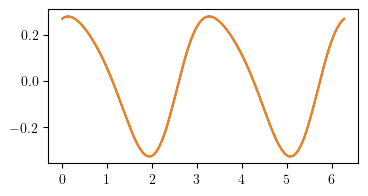

In [38]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a12.x,tot)
axs.plot(a12.x,a12.system1.h['dat'][0])

## eps^2 coeffs

In [39]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a12,1)

6 (array([ 0,  2,  4,  6,  8, 10]),)
5 (array([ 2,  4,  6,  8, 10]),)
re [  47.92076809  -77.16313574 -135.01188252  -37.26282693   -3.18232803   -0.5261593 ]
im [3.03619624e+03 4.19056876e+02 5.25397094e+01 5.08364980e+00 3.43137026e-01]


In [40]:
tot = call_fourier_series(a12,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a12,coeffs_re,coeffs_im,fr,fi))

0.0468+2*cos(x*2.0)*(-0.0754)+2*cos(x*4.0)*(-0.1318)+2*cos(x*6.0)*(-0.0364)+2*cos(x*8.0)*(-0.0031)+2*cos(x*10.0)*(-0.0005)-2*sin(x*2.0)*(2.9650)-2*sin(x*4.0)*(0.4092)-2*sin(x*6.0)*(0.0513)-2*sin(x*8.0)*(0.0050)-2*sin(x*10.0)*(0.0003)


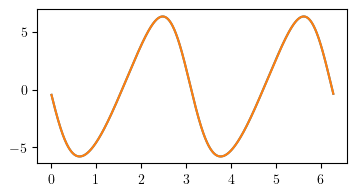

In [41]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a12.x,tot)
axs.plot(a12.x,a12.system1.h['dat'][1])

## eps^3 coeffs

In [42]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a12,2)

In [43]:
# tot = call_fourier_series(a12,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a12,coeffs_re,coeffs_im,fr,fi))

In [44]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(a12.x,tot)
# axs.plot(a12.x,a12.system1.h['dat'][2])

## Save data

In [45]:
# xlo = a12.x[0]
# xhi = a12.x[-1]
# npts = len(a12.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a12.system1.miter):
#     d = a12.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a12._n[1],a12._m[1],k),d,
#               fmt='%.18f')

# 2:3

In [46]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm23 = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',3),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [47]:
del23_p002 = 0.0001
a23 = nm.nmCoupling(**kw_nm23, del1=del23_p002)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_thalf0_v0[1]*p_thalf0[1] + eps**2*(f1*i_thalf0_v0[1]*p_thalf0[1] + f2*i_thalf0_v0[0]) + eps*f1*i_thalf0_v0[0]
p sym k 0
p sym k f_imp1(th1)*iv0_0(th0)
h sym 0 f_imp1(th1)*zv0_0(th0)
h sym 1 f_imp1(th1)*zv0_1(th0)*p_thalf0[1] + f_imp2(th1)*zv0_0(th0)
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


## eps coeffs

In [48]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a23,0)

2 (array([ 6, 12]),)
2 (array([ 6, 12]),)
re [24.9922989 -0.1135933]
im [24.88011787  0.21426511]


In [49]:
tot = call_fourier_series(a23,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a23,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*6.0)*(0.0244)+2*cos(x*12.0)*(-0.0001)-2*sin(x*6.0)*(0.0243)-2*sin(x*12.0)*(0.0002)


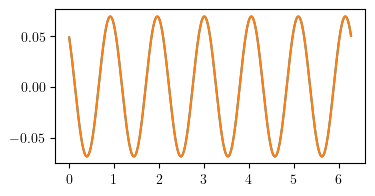

In [50]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a23.x,tot)
axs.plot(a23.x,a23.system1.h['dat'][0])

## eps^2 coeffs

In [51]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a23,1)

3 (array([ 0,  6, 12]),)
3 (array([ 6, 12, 18]),)
re [ -78.45034457 -255.93801701    7.91283027]
im [6.20660544e+02 1.14239285e+01 2.31104868e-01]


In [52]:
tot = call_fourier_series(a23,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a23,coeffs_re,coeffs_im,fr,fi))

-0.0766+2*cos(x*6.0)*(-0.2499)+2*cos(x*12.0)*(0.0077)-2*sin(x*6.0)*(0.6061)-2*sin(x*12.0)*(0.0112)-2*sin(x*18.0)*(0.0002)


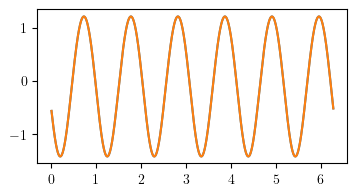

In [53]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a23.x,tot)
axs.plot(a23.x,a23.system1.h['dat'][1])

## eps^3 coeffs

In [54]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a23,2)

In [55]:
# tot = call_fourier_series(a23,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a23,coeffs_re,coeffs_im,fr,fi))

In [56]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(a23.x,tot)
# axs.plot(a23.x,a23.system1.h['dat'][2])

## Save data

In [57]:
# xlo = a23.x[0]
# xhi = a23.x[-1]
# npts = len(a23.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a23.system1.miter):
#     d = a23.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a23._n[1],a23._m[1],k),d,
#               fmt='%.18f')